In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
import swat
import time
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')

# For the dataset without nulled consumers

In [3]:
df = pd.read_csv('data/dataset_without_nulled.csv', low_memory=False).drop(columns={'Installation_zone'})
df.head(5)

,Year,Month,Consumer_number,Consumer_type,Consumption
0,2013,1,21018,1,0
1,2013,1,36690,2,5
2,2013,1,17940,1,6
3,2013,1,14273,1,1
4,2013,1,5,1,13


In [4]:
monthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [5]:
df_1 = df[df['Year'] == 2019].drop(columns={'Year'})
df_1 = df_1.drop_duplicates().fillna(0)
df_1= df_1.groupby(['Consumer_number', 'Month', 'Consumer_type'], as_index = False).sum()
df_1 = df_1.drop(df_1.index[0])
df_1.head(5)

,Consumer_number,Month,Consumer_type,Consumption
1,1,5,3,208
2,1,7,3,219
3,1,8,3,308
4,5,1,1,8
5,5,5,1,8


In [6]:
df_pivot = df_1.pivot(index = 'Consumer_number', columns = 'Month', values = 'Consumption').fillna(0)
# print("len with nulled:", len(df_pivot))
df_pivot = df_pivot.rename_axis(None,axis=1).set_axis(monthes, inplace=False, axis=1).reset_index()
df_pivot = df_pivot.loc[~df_pivot[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].apply(lambda row: (row==0).all(), axis=1)]
print(df_pivot.head(5))
print("len without nulled:", len(df_pivot))

len without nullded: 16519


In [7]:
x = df_pivot.loc[:, monthes].values
print('x shape:', x.shape)
y = df_pivot.loc[:,['Consumer_number']].values
print('y shape:', y.shape)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['x', 'y'])

x shape: (16519, 12)
y shape: (16519, 1)


NameError: name 'PCA' is not defined

In [26]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_pivot)
tsne_results

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16519 samples in 0.042s...
[t-SNE] Computed neighbors for 16519 samples in 0.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16519
[t-SNE] Computed conditional probabilities for sample 2000 / 16519
[t-SNE] Computed conditional probabilities for sample 3000 / 16519
[t-SNE] Computed conditional probabilities for sample 4000 / 16519
[t-SNE] Computed conditional probabilities for sample 5000 / 16519
[t-SNE] Computed conditional probabilities for sample 6000 / 16519
[t-SNE] Computed conditional probabilities for sample 7000 / 16519
[t-SNE] Computed conditional probabilities for sample 8000 / 16519
[t-SNE] Computed conditional probabilities for sample 9000 / 16519
[t-SNE] Computed conditional probabilities for sample 10000 / 16519
[t-SNE] Computed conditional probabilities for sample 11000 / 16519
[t-SNE] Computed conditional probabilities for sample 12000 / 16519
[t-SNE] Computed conditional probabilities for sa

array([[ -2.0039687,  11.297062 ],
       [ -1.9912376,  11.297632 ],
       [ -1.9907911,  11.2976465],
       ...,
       [ -5.5397625, -11.377985 ],
       [ -5.5402365, -11.380238 ],
       [ -5.5363636, -11.359491 ]], dtype=float32)

In [46]:
df_subset = pd.DataFrame(data=tsne_results, columns=['tsne-one', 'tsne-two'])
df_subset

,tsne-one,tsne-two
0,-2.003969,11.297062
1,-1.991238,11.297632
2,-1.990791,11.297647
3,-1.990395,11.297668
4,-1.990217,11.297686
...,...,...
16514,-5.539591,-11.377161
16515,-5.539634,-11.377396
16516,-5.539762,-11.377985
16517,-5.540236,-11.380238


In [38]:
clf = DBSCAN(eps=0.25, min_samples=3).fit(df_subset)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)
len(labels)


Clusters discovered: 13


16519

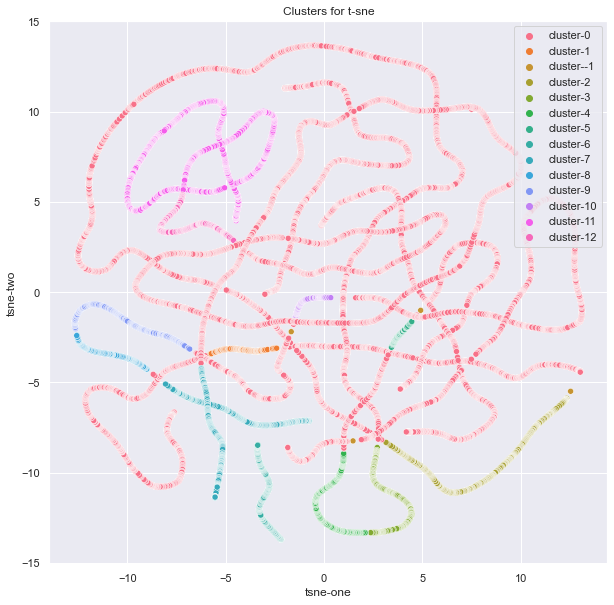

In [54]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(df_subset['tsne-one'], df_subset['tsne-two'], hue=["cluster-{}".format(x) for x in labels])
plt.title('Clusters for t-sne')
plt.savefig("charts/dbscan/dbscan_t-sne_clusters.png", bbox_inches='tight')
plt.show()

In [39]:
resultDf = pd.merge(df_subset, df_pivot['Consumer_number'], left_index=True, right_index=True)
print(resultDf.head(5))

   tsne-one   tsne-two  Consumer_number
0 -2.003969  11.297062                1
1 -1.991238  11.297632                5
2 -1.990791  11.297647               11
3 -1.990395  11.297668               15
4 -1.990217  11.297686               16


In [76]:
# label = pd.DataFrame({'Label': labels})
# resultDf = resultDf.join(label).drop(columns={'tsne-one', 'tsne-two'})
# resultDf.head(5)
resultDf_1 = resultDf[resultDf['Label'] == 0]
len(resultDf_1)

10557

In [41]:
tipo_de_cons = df.drop(columns={'Month'})
tipo_de_cons = tipo_de_cons[tipo_de_cons['Year'] == 2019].drop(columns={'Year'})
# tipo_de_cons = tipo_de_cons.groupby(columns=['Consumer_number', 'Consumer_type'])
tipo_de_cons = tipo_de_cons.groupby(['Consumer_number', 'Consumer_type'], as_index=False).sum()
tipo_de_cons.head(5)

,Consumer_number,Consumer_type,Consumption
0,1,3,766
1,5,1,24
2,11,1,16
3,15,2,22
4,16,1,31


In [72]:
df_2 = pd.merge(resultDf, tipo_de_cons, on="Consumer_number")
df_2 = df_2.drop(columns={'Consumer_number', 'Consumption'})
df_2['Count'] = df_2['Consumer_type']
df_2

,Label,Consumer_type,Count
0,0,3,3
1,0,1,1
2,0,1,1
3,0,2,2
4,0,1,1
...,...,...,...
14663,7,1,1
14664,7,2,2
14665,7,1,1
14666,7,1,1


In [77]:
df_final = df_2.groupby(['Label', 'Consumer_type'], as_index=False).agg({'Count':'count'})
print(df_final)
print(len(df_final))
print(df_final['Label'].unique())

     Label  Consumer_type  Count
0       -1              1      1
1       -1              9      1
2       -1             19      1
3        0              1   7052
4        0              2    590
..     ...            ...    ...
101     12              9     30
102     12             12      3
103     12             18      1
104     12             19      6
105     12             20      1

[106 rows x 3 columns]
106
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


In [59]:
data = [[1, 'DOMÉSTICO'], [2, ' COM/INDUSTRIAL/OBRAS'], [3, 'UTIL.PUBLICA'], [4, 'OBRAS'], [5, 'ESTADO'], 
              [6, 'IGREJAS'], [7, 'EXP.A.RURAL'], [9, 'RURAL DOMÉSTICO'], [10, 'RURAL/ESTADO'], [11, 'FAM.NUMEROSAS'], 
              [12, 'FAM.CARENCIADAS'], [13, 'NUMER./CARENC.'], [14, 'CP.DOM/URB'], [15, 'CP.COM/URB'], [16, 'CP.DOM/RURAL'], 
              [17, 'CP.COM/RURAL'], [18, 'IPSS/IGR/RURAL'], [19, 'DOM./RURAL A.S'], [20, 'COM./RURAL A.S'], 
              [21, 'REGA'], [22, 'CMB']]
cons_tipos = pd.DataFrame(data, columns = ['Consumer_type', 'Name'])
cons_tipos

,Consumer_type,Name
0,1,DOMÉSTICO
1,2,COM/INDUSTRIAL/OBRAS
2,3,UTIL.PUBLICA
3,4,OBRAS
4,5,ESTADO
5,6,IGREJAS
6,7,EXP.A.RURAL
7,9,RURAL DOMÉSTICO
8,10,RURAL/ESTADO
9,11,FAM.NUMEROSAS


In [60]:
df_final = pd.merge(df_final, cons_tipos, on="Consumer_type").drop(columns={'Consumer_type'}).rename(columns={'Name':'Consumer_type'})
df_final

,Label,Count,Consumer_type
0,-1,1,DOMÉSTICO
1,0,7052,DOMÉSTICO
2,1,102,DOMÉSTICO
3,2,515,DOMÉSTICO
4,3,274,DOMÉSTICO
...,...,...,...
101,11,2,IPSS/IGR/RURAL
102,12,1,IPSS/IGR/RURAL
103,0,5,COM./RURAL A.S
104,4,1,COM./RURAL A.S


In [63]:
df_final.loc[df_final["Label"] == -1, "Label"] = 20
df_final.head()

,Label,Count,Consumer_type
0,20,1,DOMÉSTICO
1,0,7052,DOMÉSTICO
2,1,102,DOMÉSTICO
3,2,515,DOMÉSTICO
4,3,274,DOMÉSTICO


In [65]:
df_pivot = pd.pivot(df_final, values='Count', index=['Label'],
                    columns=['Consumer_type']).fillna(0)
df_pivot = df_pivot.rename_axis(None,axis=1).reset_index()
df_pivot

,Label,COM/INDUSTRIAL/OBRAS,COM./RURAL A.S,CP.DOM/URB,DOM./RURAL A.S,DOMÉSTICO,ESTADO,EXP.A.RURAL,FAM.CARENCIADAS,FAM.NUMEROSAS,IGREJAS,IPSS/IGR/RURAL,OBRAS,RURAL DOMÉSTICO,RURAL/ESTADO,UTIL.PUBLICA
0,0,590.0,5.0,20.0,255.0,7052.0,40.0,55.0,38.0,3.0,2.0,12.0,58.0,2387.0,12.0,28.0
1,1,6.0,0.0,2.0,0.0,102.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2,25.0,0.0,3.0,0.0,515.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,2.0
3,3,18.0,0.0,1.0,0.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,16.0,1.0,0.0,62.0,189.0,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5,2.0,0.0,1.0,1.0,57.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,3.0,0.0,0.0,0.0,47.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,242.0,4.0,0.0
7,7,44.0,0.0,0.0,6.0,269.0,0.0,5.0,5.0,0.0,0.0,2.0,6.0,181.0,2.0,1.0
8,8,3.0,0.0,0.0,0.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0
9,9,9.0,0.0,3.0,2.0,92.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,178.0,5.0,0.0


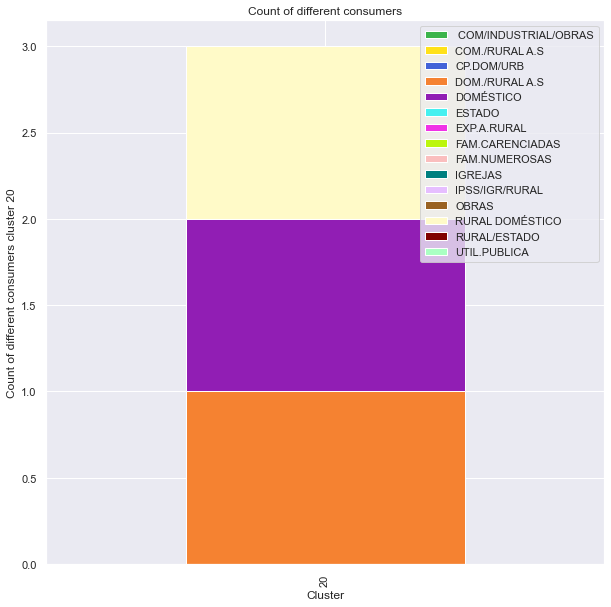

In [66]:
df_pivot_3 = df_pivot.loc[ (df_pivot.Label == 20)]
df_pivot_3.plot(figsize=(10,10), x = 'Label', kind='bar', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers cluster 20')
 
# title of plot
plt.title('Count of different consumers')
plt.savefig("charts/dbscan/dbscan_pca_cluster_20_profile.png", bbox_inches='tight')
plt.show()

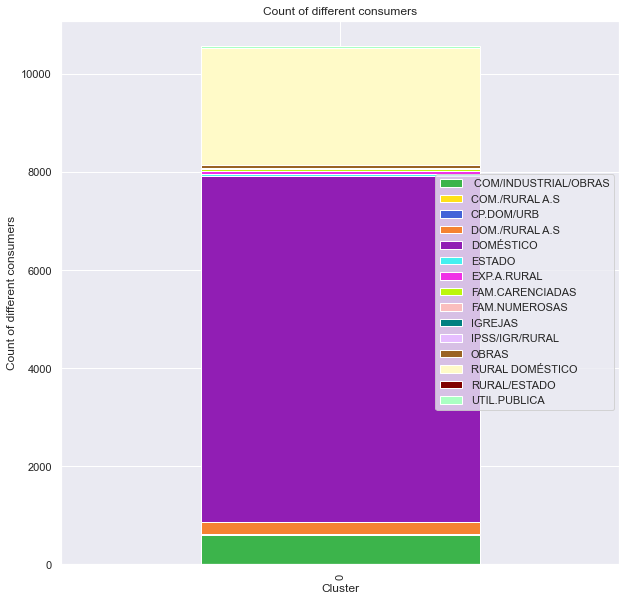

In [69]:
df_pivot_1 = df_pivot.loc[df_pivot['Label'] == 0]

df_pivot_1.plot(figsize=(10,10), x = 'Label', kind='bar', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers')
 
# title of plot
plt.title('Count of different consumers')
plt.savefig("charts/dbscan/dbscan_pca_cluster0_profile.png", bbox_inches='tight')
plt.show()

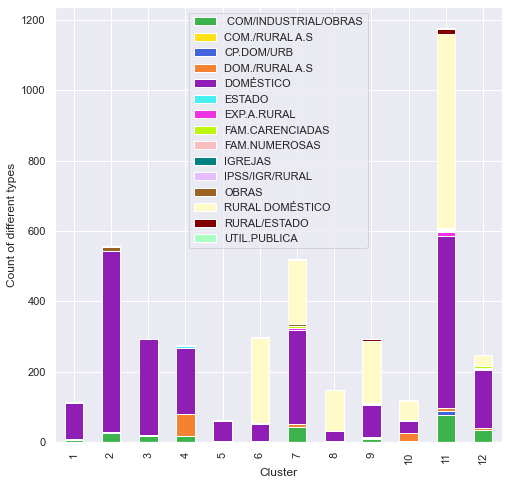

In [70]:
df_pivot_2 = df_pivot[df_pivot.Label != 20]
df_pivot_2 = df_pivot_2[df_pivot_2.Label != 0]
df_pivot_2.plot.bar(figsize=(8,8), x = 'Label', stacked=True, color=['#3cb44b', '#ffe119', '#4363d8', 
                                                                     '#f58231', '#911eb4', '#46f0f0', '#f032e6',  '#bcf60c', 
                                                                     '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                                                                     '#800000', '#aaffc3', '#ffd8b1', 
                                                                     '#000075', '#808080'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different types')

plt.savefig("charts/dbscan/dbscan_t-sne_profiles.png", bbox_inches='tight', sharex=False)
plt.show()

In [49]:
df_pivot_1 = df_pivot.drop(index=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
df_pivot_1

Consumer_type,1,2,3,4,5,6,7,9,10,11,12,14,18,19,20
1,7052.0,590.0,28.0,58.0,40.0,2.0,55.0,2387.0,12.0,3.0,38.0,20.0,12.0,255.0,5.0


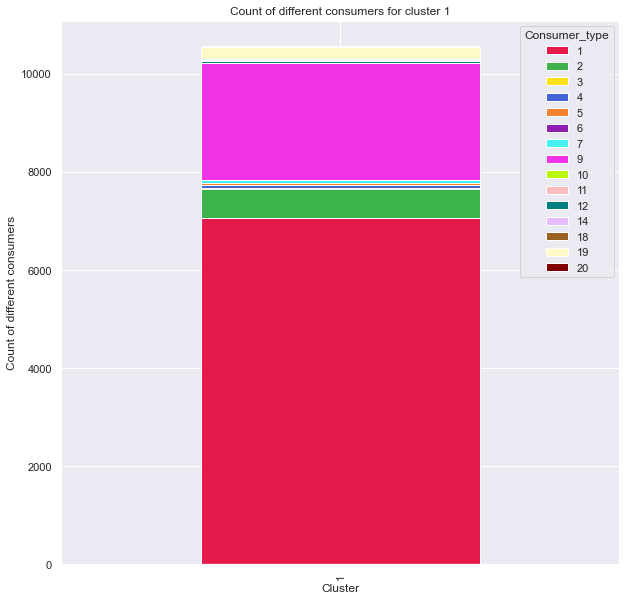

In [56]:
df_pivot_1.plot(figsize=(10,10), kind='bar', stacked=True, color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                               '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', 
                                               '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
plt.xlabel('Cluster')
plt.ylabel('Count of different consumers')
 
# title of plot
plt.title('Count of different consumers for cluster 1')
plt.savefig("charts/dbscan/dbscan_t-sne_cluster1_profile.png", bbox_inches='tight')
plt.show()

In [57]:
df_pivot2 = df_pivot.drop(index=[1])

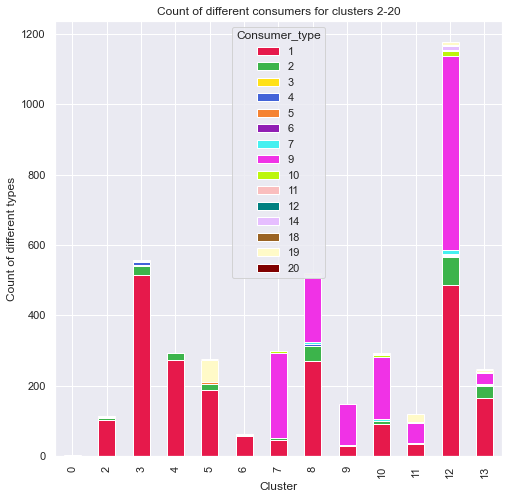

In [58]:
df_pivot2.plot(figsize=(8,8), kind='bar', stacked=True, color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                               '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', 
                                               '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
 
# labels for x & y axis
plt.xlabel('Cluster')
plt.ylabel('Count of different types')
 
# title of plot
plt.title('Count of different consumers for clusters 2-20')
plt.savefig("charts/dbscan/dbscan_t-sne_profile.png", bbox_inches='tight')
plt.show()